# Yurii Slivinskyi
## Eyeglasses segmentation using U-Net architecture with TensorFLow

# Table of content
1. [Packages](#packages)
2. [Data loading and observation](#data-loading-and-observation)
3. [Model architecture](#model-architecture)
4. [Model training](#model-training)
5. [Model evaluation](#model-evaluation)
6. [Comparing CPU and GPU](#comparing-cpu-and-gpu)

## Packages

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
import imageio.v2 as imageio

## Data loading and observation

In [20]:
PATH = '/kaggle/input/eyeglasses-segmentation/eyeglasses_dataset/'
IMG_SIZE = (512, 512, 3)

image_path = os.path.join(PATH, './train/images/')
mask_path = os.path.join(PATH, './train/masks/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in mask_list_orig]
image_list.sort()
mask_list.sort()

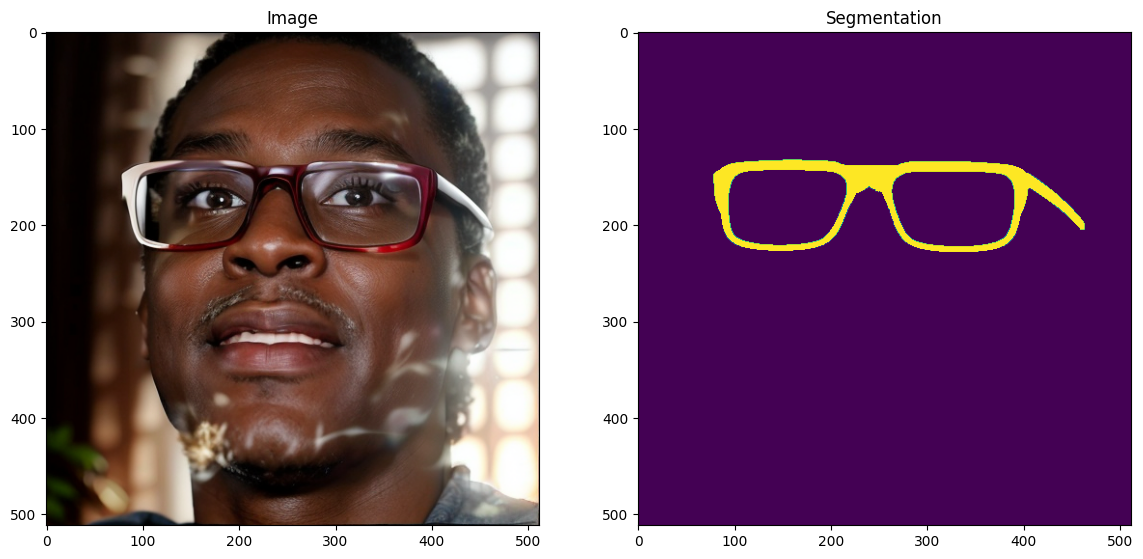

In [21]:
img = imageio.imread(image_list[1])
mask = imageio.imread(mask_list[1])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')
plt.show()

Input data is images 512 x 512 and binary mask with classes eyeglasses / not eyeglasses. Despite all images are the same size it will be usefull to create preprocessing pipeline for the future use.

In [22]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

In [23]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, IMG_SIZE[:2], method='nearest')
    input_mask = tf.image.resize(mask, IMG_SIZE[:2], method='nearest')
    input_mask /= 255

    return input_image, input_mask

In [24]:
def load_data(path, subset):
    image_path = os.path.join(path, f'./{subset}/images/')
    mask_path = os.path.join(path, f'./{subset}/masks/')
    image_list_orig = os.listdir(image_path)
    mask_list_orig = os.listdir(mask_path)
    image_list = [image_path+i for i in image_list_orig]
    mask_list = [mask_path+i for i in mask_list_orig]
    image_list.sort()
    mask_list.sort()
    print(f'Number of {subset} examples: {len(image_list)}')
    
    image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
    mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
    
    image_filenames = tf.constant(image_list)
    masks_filenames = tf.constant(mask_list)

    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
    
    image_ds = dataset.map(process_path)

    return image_ds.map(preprocess)

In [25]:
train = load_data(PATH, 'train')
val = load_data(PATH, 'val')
test = load_data(PATH, 'test')

Number of train examples: 1992
Number of val examples: 489
Number of test examples: 10


## Model architecture

I will be using standart U-Net architecture with first encodeing and then decoding layers. As an encoder I'll use pretrained model - MobileNetV2. From encoder will be 5 skip connection to decoder. That will allow model learn complex features not only depth-wise, but resolution-wise too. Also that will help with vanishing/exploding gradient.
Decoding layers will have this structure:
- Concatenation of previous layer outputs with outputs skip connection from encoder
- Transpose convolution to double output width and height
- Two layers of normal convolution with same padding
After decoding process output will be followed with 1x1 convolution layer to get the final output of shape 512x512x2, where will be displayed result for each pixel and logits for classes eyeglasses / not eyeglasses

In [11]:
def decoder(input, skip, n_filters=64):
    tmp = input
    tmp = tfl.Concatenate()([tmp, skip])
    tmp = tfl.Conv2DTranspose(filters=n_filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(tmp)
    tmp = tfl.Conv2D(n_filters//2, 2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(tmp)
    tmp = tfl.Conv2D(n_filters, 2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(tmp)
    return tmp
    

In [12]:
def unet(input_shape=(512, 512, 3), n_classes=2):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

    skip_connections = [
        'block_1_expand_relu',   
        'block_3_expand_relu',   
        'block_6_expand_relu',   
        'block_13_expand_relu',  
        'block_16_project',      
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in skip_connections]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable = False
    
    inputs = tf.keras.layers.Input(shape=input_shape)

    skips = down_stack(inputs)
    x = skips[-1]
    
    for  i, skip in enumerate(skips[::-1]):
        x = decoder(x, skip, n_filters=16 * (2 ** i))
    
    x = tf.keras.layers.Conv2D(
      filters=n_classes, kernel_size=1, strides=1,
      padding='same')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

For loss function we'll be using SparseCategoricalCrossentropy. \
As main perfomance I chosed Mean Intersection over Union. Giving the high class imbalance in each image metric needs to be robust to that class imbalance. 
MeanIoU calculated as $ \frac{TP}{TP + FP + FN} $, where TP is a number of true positives, FP - number of false positives and FN is number of false negatieves. This metric allows us to correctly evaluate model's perfomance, despite class imbalance. \ 
As optimisation algorithm we will use ADAM with learning rate of 0.001.

In [14]:
N_CLASSES = 2

model = unet(input_shape=IMG_SIZE,n_classes=N_CLASSES)
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.MeanIoU(num_classes=2, sparse_y_pred=False),'accuracy'])

/tmp/ipykernel_34/4023171795.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 256, 256, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 128,  │            │                   │
│                     │ 128, 144), (None, │            │                   │
│                     │ 64, 64, 192),     │            │                   │
│                     │ (None, 32, 32,    │            │                   │
│                     │ 576), (None, 16,  │            │                   │
│                     │ 16, 320)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ functional_1[0][… │
│ (Concatenate)       │ 640)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     92,176 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32, 8) │        520 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │        528 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 592)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    170,528 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      2,064 │ conv2d_transpose… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,080 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 224)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    129,088 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      8,224 │ conv2d_transpose… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      8,256 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 208)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,340,314 (12.74 MB)

 Trainable params: 1,498,330 (5.72 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

## Model training

Because more than a half of out model is pretrained, we will use small number of epoch and later we always can do more epochs. Also we will use early stopping to prevent overtraining of our model.

In [24]:
EPOCHS = 15
BATCH_SIZE = 8
train_dataset = train.cache().shuffle(buffer_size=1000).batch(BATCH_SIZE)
validation_dataset = val.batch(BATCH_SIZE)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    min_delta=1e-6,
                                                    patience=4,
                                                    verbose=1)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                         validation_data=validation_dataset,
                         callbacks=[early_stopping])

Epoch 1/15


I0000 00:00:1717692207.778425     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


498/498 ━━━━━━━━━━━━━━━━━━━━ 329s 509ms/step - accuracy: 0.9748 - loss: 0.0948 - mean_io_u: 0.6017 - val_accuracy: 0.9888 - val_loss: 0.0306 - val_mean_io_u: 0.8534
Epoch 2/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 233s 468ms/step - accuracy: 0.9932 - loss: 0.0185 - mean_io_u: 0.8637 - val_accuracy: 0.9933 - val_loss: 0.0214 - val_mean_io_u: 0.8988
Epoch 3/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 233s 467ms/step - accuracy: 0.9946 - loss: 0.0148 - mean_io_u: 0.8886 - val_accuracy: 0.9913 - val_loss: 0.0255 - val_mean_io_u: 0.8757
Epoch 4/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 233s 467ms/step - accuracy: 0.9945 - loss: 0.0148 - mean_io_u: 0.8889 - val_accuracy: 0.9940 - val_loss: 0.0164 - val_mean_io_u: 0.9116
Epoch 5/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 233s 467ms/step - accuracy: 0.9953 - loss: 0.0129 - mean_io_u: 0.9028 - val_accuracy: 0.9942 - val_loss: 0.0150 - val_mean_io_u: 0.9102
Epoch 6/15
498/498 ━━━━━━━━━━━━━━━━━━━━ 233s 467ms/step - accuracy: 0.9956 - loss: 0.0117 - mean_io_u: 0.9068 - val_accuracy: 0.995

Metric on training and validation data are looking pretty good. Let's look at trainig info and some examples from validation set.

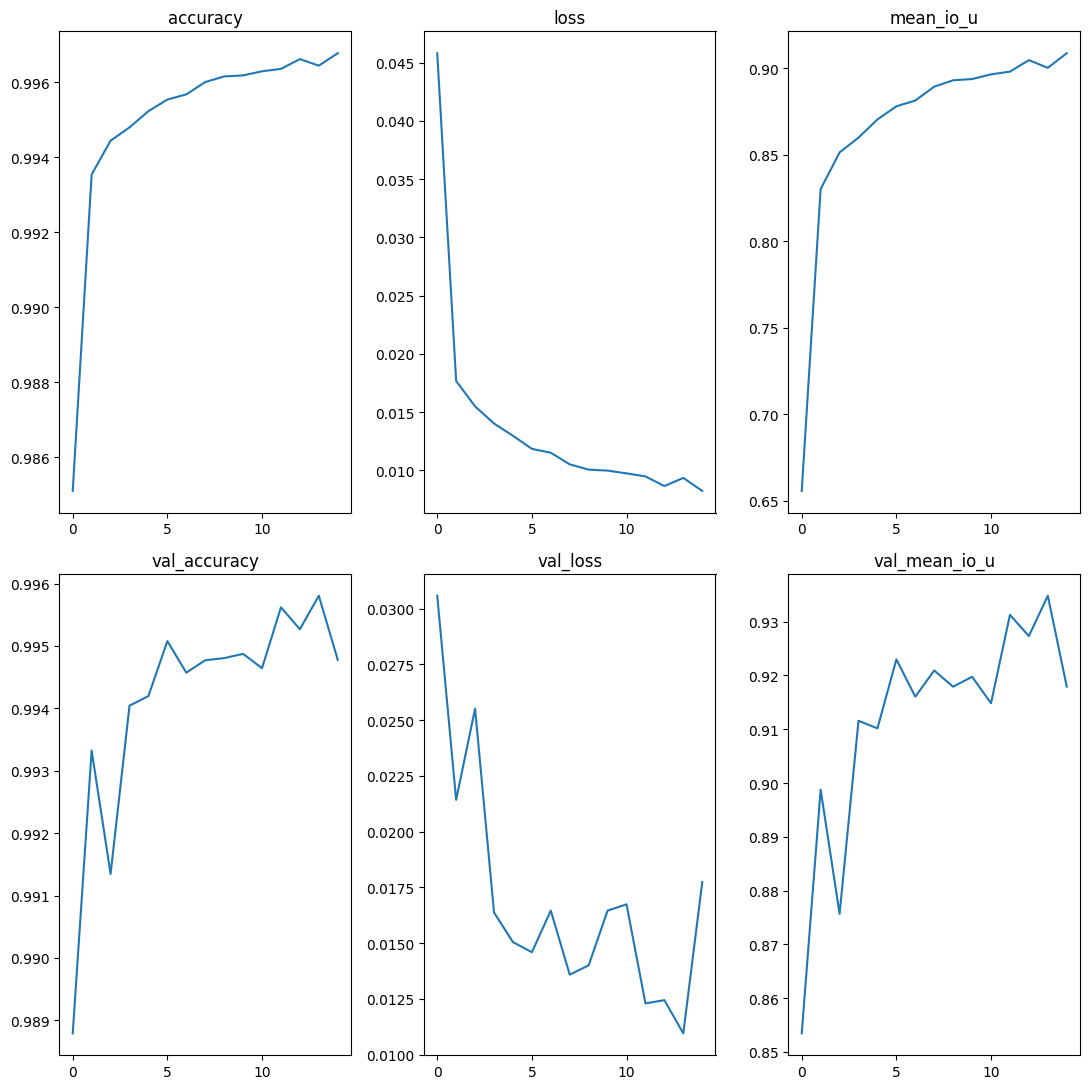

In [44]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(11, 11))
axs = axs.ravel()

for id, value in enumerate(model_history.history):
    axs[id].plot(model_history.history[value])
    axs[id].set(title=value)


fig.tight_layout()
plt.show()

## Model evaluation

Training perfomance is more smoother tha validation, but it's ok

In [40]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [41]:
def display(display_list):
    fig, axs = plt.subplots(ncols=3, figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    iou = tf.metrics.MeanIoU(num_classes=2)(display_list[1], display_list[2])
    ac = tf.metrics.Accuracy()(display_list[1], display_list[2])
    stats = f" IoU: {iou: .3f}\nAccuracy: {ac: .3f}"

    for i in range(len(display_list)):
        axs[i].set(title = title[i])
        axs[i].imshow(tf.keras.utils.array_to_img(display_list[i]))
        
        axs[i].axis('off')
    axs[2].text(
            0.05, 0.95,
            stats,
            transform=axs[2].transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#f994a6', alpha=0.5)
        )
    plt.show()

In [42]:
def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


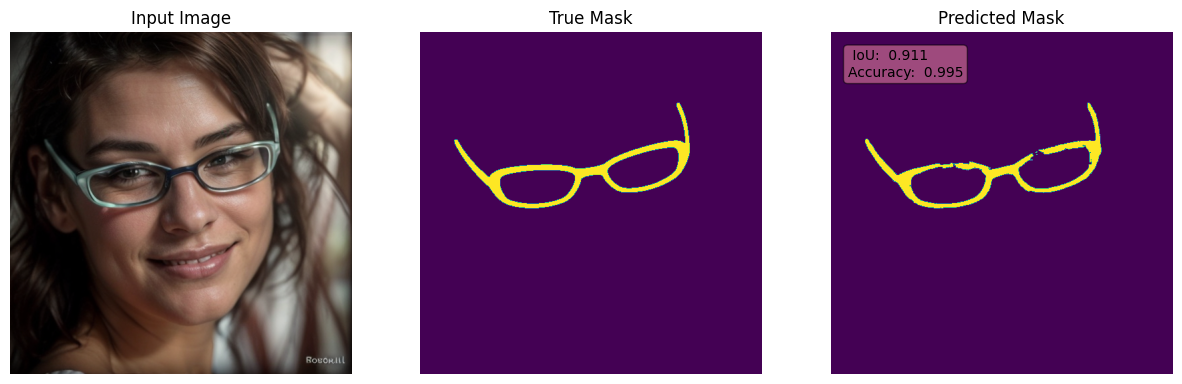

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


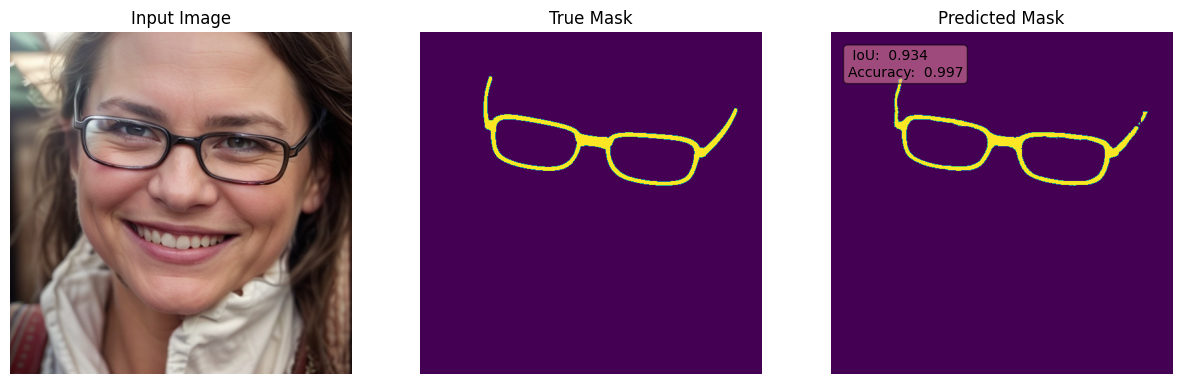

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


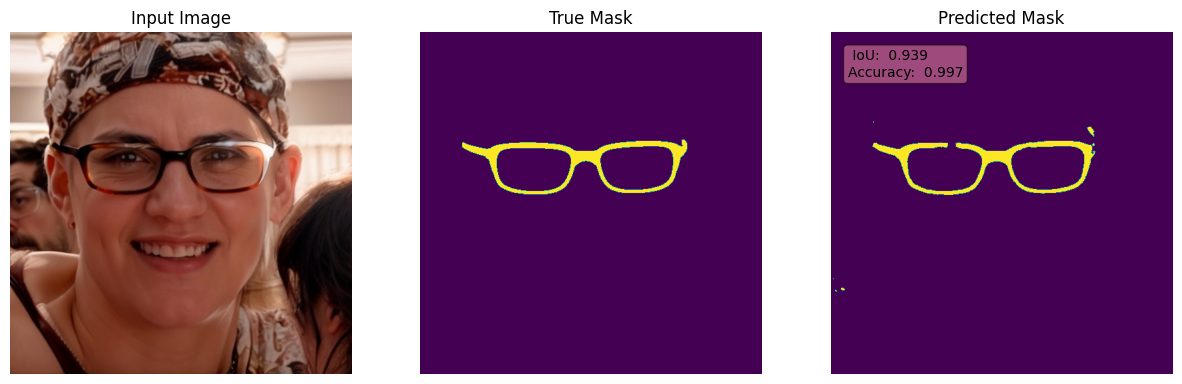

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


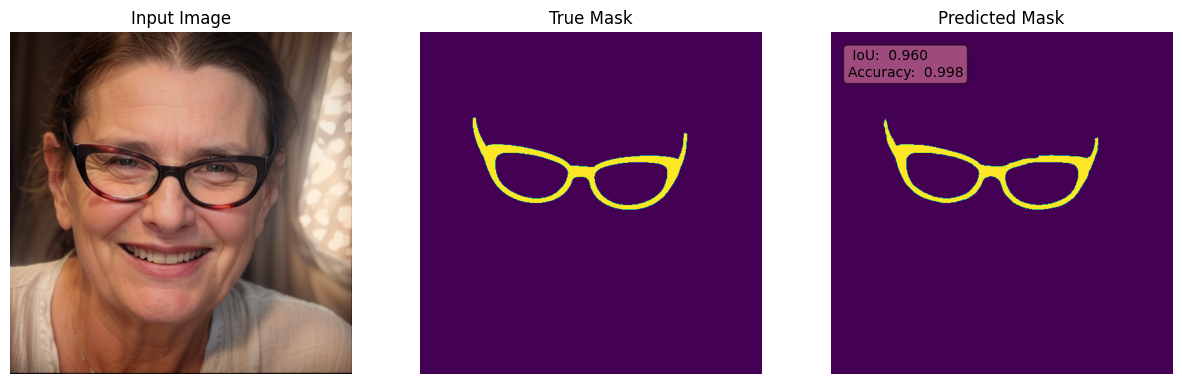

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


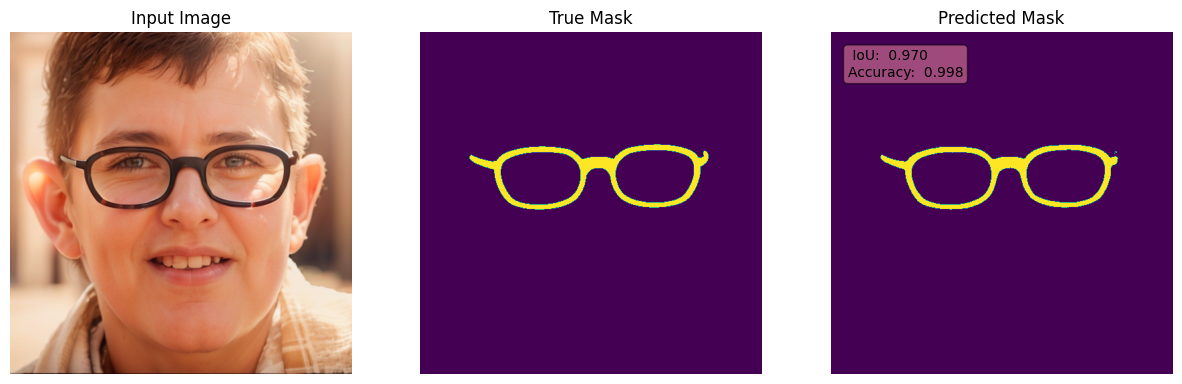

In [42]:
validation_dataset = val.shuffle(100).batch(1)
show_predictions(validation_dataset, 5)

Looking at the prediction I can say that perfomance are pretty good, but there are small problems with eyebrows and generally dark images. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


I0000 00:00:1717769300.467517     189 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


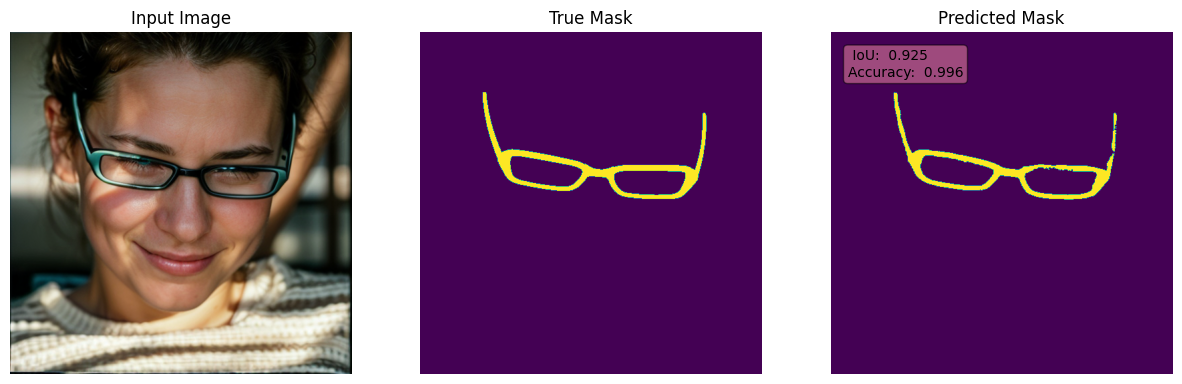

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


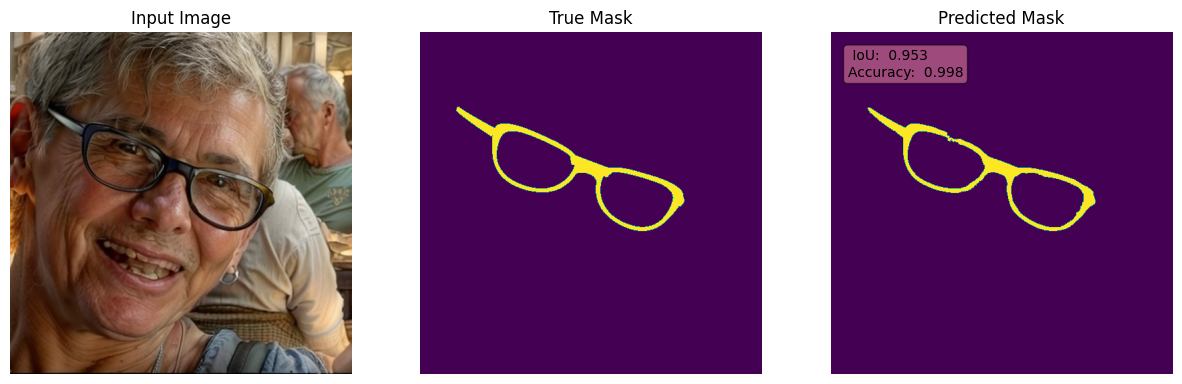

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


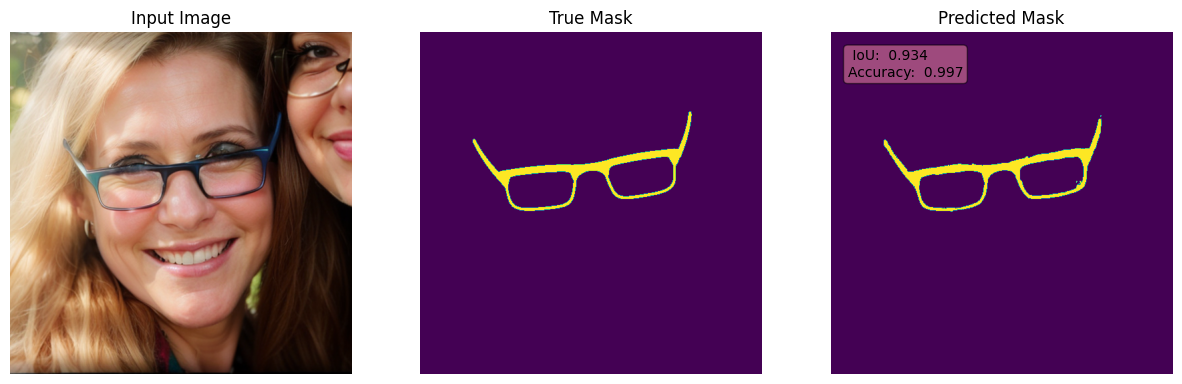

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


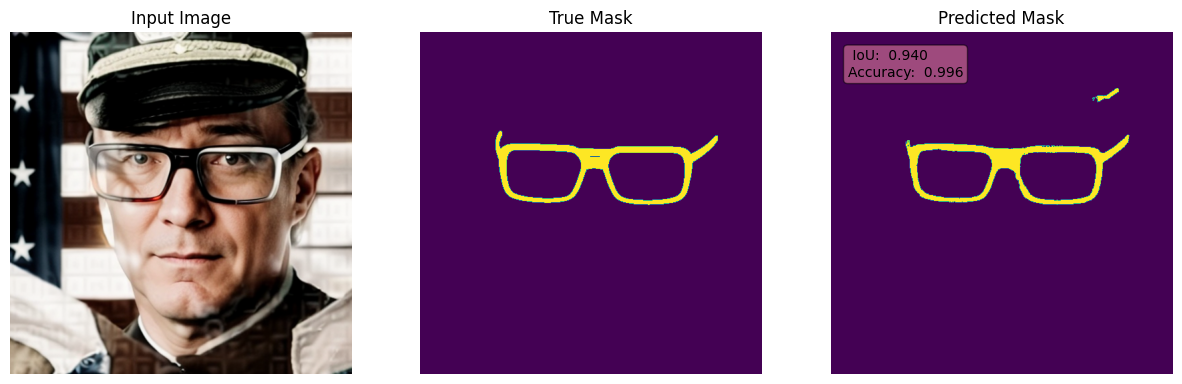

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


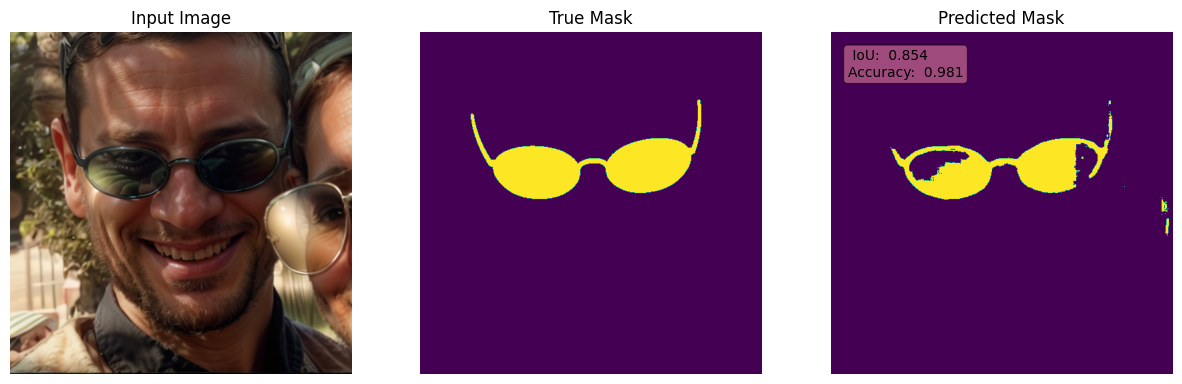

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


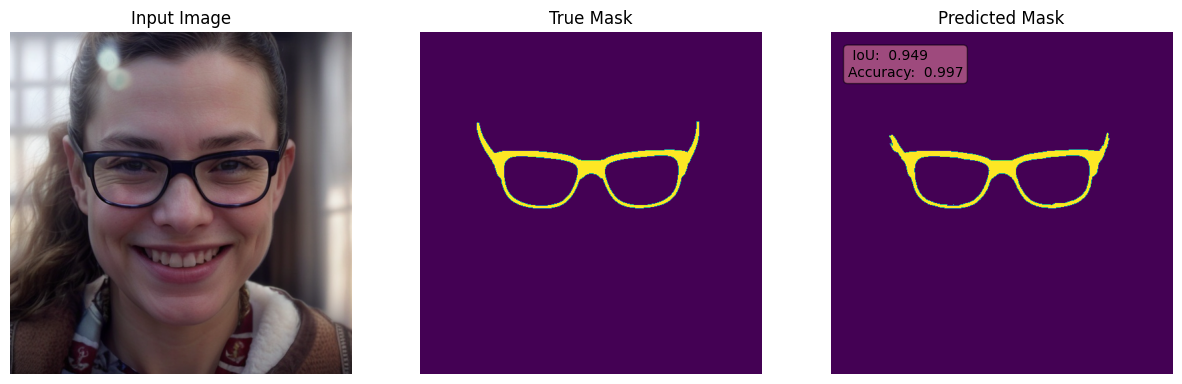

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


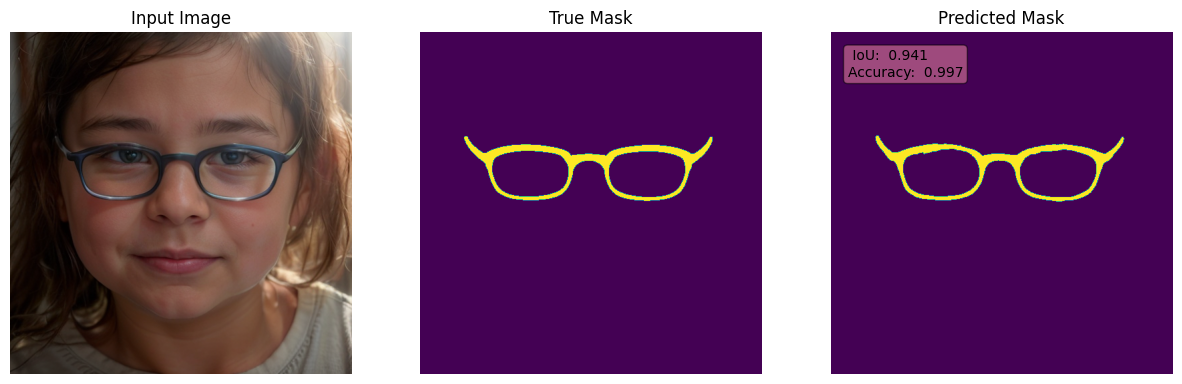

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


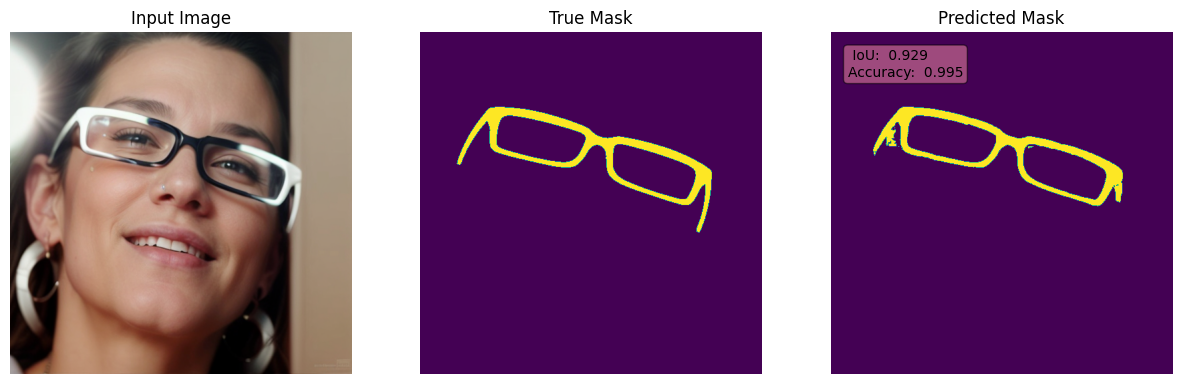

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


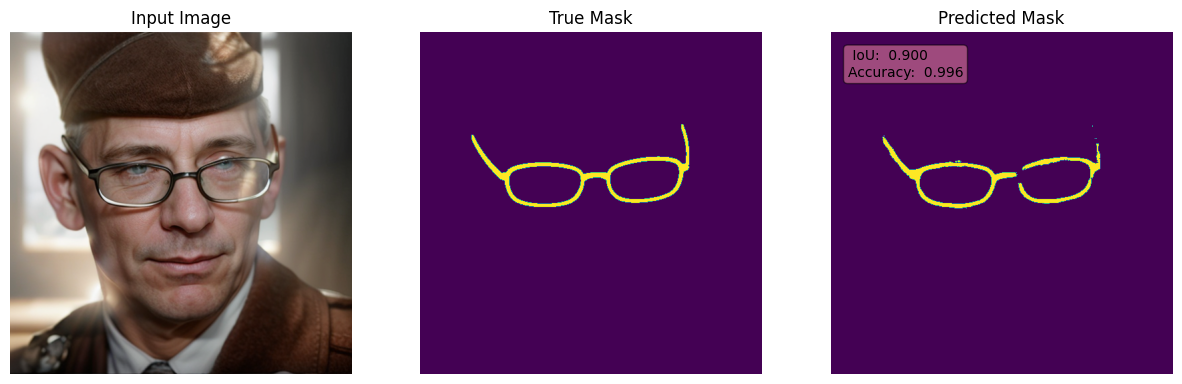

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


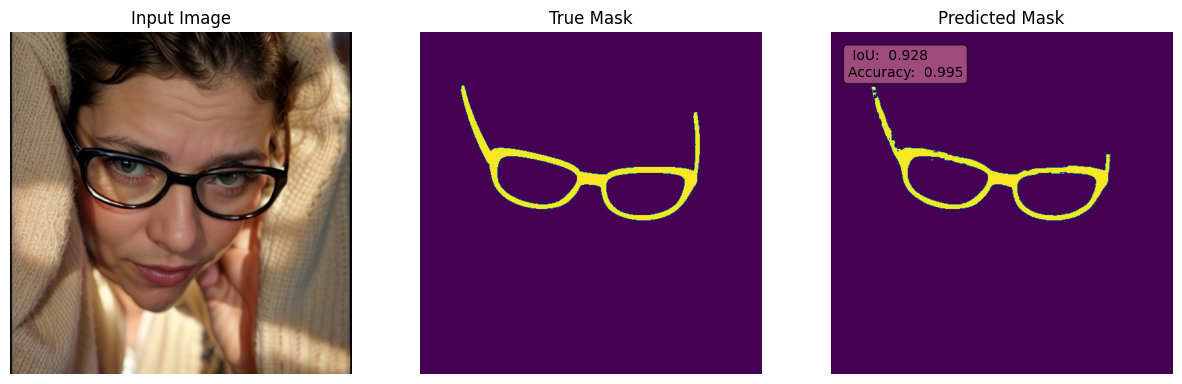

In [43]:
test_dataset = test.batch(1)
show_predictions(test_dataset, 10)

Test results are good aswell, but there are a problem with half-transparent eyeglasses, but I am satisfied with the results.

In [39]:
model.save('model.keras')

## Comparing CPU and GPU 

Now let's compare how long it takes for that model to predict entire test set on CPU(Intel Xeon 2.20 GHz) and GPU(Nvidia Tesla P100)

In [29]:
import time

In [51]:
def time_predictions(func):
    def wrapper(*args, **kwargs): 
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter() -start
        print(f'Time taken: {end}\n')
        return
    return wrapper

In [77]:
@time_predictions
def make_predictions(dataset, device, num=10):
    print(f'Making predictions using {device}')
    with tf.device('/'+device+':0'):
        for image, mask in dataset.take(num):
            model(image)
    return

In [78]:
make_predictions(test_dataset, 'GPU')

Making predictions using GPU
Time taken: 4.482733028999974



In [79]:
make_predictions(test_dataset, 'CPU')

Making predictions using CPU
Time taken: 21.942392304999885



There are clearly a big difference at execution speed